## Vanilla CNN model for EEG data: Subject-Wise Training

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Project - C147/project/

/content/drive/.shortcut-targets-by-id/1-ZqOst-RT6vlWrAPZPiqbkETxbuIXYY1/Project - C147/project


In [3]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [4]:
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:1000]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample) - resultant vec has 400 points - downsampling; performing low pass filtering on EEG signals
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    #first: mean pooling - downsampling method; smoothing
    #second: add Gaussian noise; regularizing effect
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average)) #vertical stacking; 4230 samples after stacking; size of dataset increased; each of dimension 22x400
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling + noise addition

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:1000]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

## Data Preprocessing to subset Subject 1 data points

In [5]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769

In [6]:
print(person_train_valid.shape)
print(type(person_train_valid))
print(np.unique(person_train_valid), '\n')
print(person_test.shape)
print(type(person_test))
print(np.unique(person_test))

(2115, 1)
<class 'numpy.ndarray'>
[0. 1. 2. 3. 4. 5. 6. 7. 8.] 

(443, 1)
<class 'numpy.ndarray'>
[0. 1. 2. 3. 4. 5. 6. 7. 8.]


In [7]:
# Find unique values and their counts in Train Val Set
unique_values, counts = np.unique(person_train_valid, return_counts=True)

# Zip the unique values and their counts for easier printing
unique_counts = list(zip(unique_values, counts))

# Print unique values and their counts
for value, count in unique_counts:
    print(f"Value: {value}, Count: {count}")

Value: 0.0, Count: 237
Value: 1.0, Count: 236
Value: 2.0, Count: 236
Value: 3.0, Count: 234
Value: 4.0, Count: 235
Value: 5.0, Count: 236
Value: 6.0, Count: 238
Value: 7.0, Count: 232
Value: 8.0, Count: 231


In [8]:
# Find unique values and their counts in Test Set
unique_values, counts = np.unique(person_test, return_counts=True)

# Zip the unique values and their counts for easier printing
unique_counts = list(zip(unique_values, counts))

# Print unique values and their counts
for value, count in unique_counts:
    print(f"Value: {value}, Count: {count}")

Value: 0.0, Count: 50
Value: 1.0, Count: 50
Value: 2.0, Count: 50
Value: 3.0, Count: 50
Value: 4.0, Count: 47
Value: 5.0, Count: 49
Value: 6.0, Count: 50
Value: 7.0, Count: 50
Value: 8.0, Count: 47


In [9]:
#Finding the indices of subject 1 samples in train and test datasets
train_val_indices = np.where(person_train_valid == 1)[0]
test_indices = np.where(person_test == 1)[0]
print(train_val_indices.shape)
print(type(train_val_indices))
print(test_indices.shape)
print(type(test_indices))

(236,)
<class 'numpy.ndarray'>
(50,)
<class 'numpy.ndarray'>


In [10]:
#Finding the subject 1 subsets from train and test sets
subject1_X_train_valid = X_train_valid[train_val_indices]
subject1_y_train_valid = y_train_valid[train_val_indices]
subject1_X_test = X_test[test_indices]
subject1_y_test = y_test[test_indices]
print(subject1_X_train_valid.shape)
print(subject1_y_train_valid.shape)
print(subject1_X_test.shape)
print(subject1_y_test.shape)

(236, 22, 1000)
(236,)
(50, 22, 1000)
(50,)


## Data Prep


In [11]:
#Proper splitting so that training set is split into training and validation sets before applying the preprocessing functions to each to ensure independent preprocessing.
from sklearn.model_selection import train_test_split

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
#all
ind_valid_all = np.random.choice(2115, 250, replace=False)
ind_train_all = np.array(list(set(range(2115)).difference(set(ind_valid_all))))
#subject 1
ind_valid = np.random.choice(236, 30, replace=False)
ind_train = np.array(list(set(range(236)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
#all
(x_train, x_valid) = X_train_valid[ind_train_all], X_train_valid[ind_valid_all]
(y_train, y_valid) = y_train_valid[ind_train_all], y_train_valid[ind_valid_all]
print('ALL DATA')
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape, '\n')

#all
x_train_prep,y_train_prep = train_data_prep(x_train,y_train,2,2,True)
x_val_prep,y_val_prep = train_data_prep(x_valid,y_valid,2,2,True)
print('ALL DATA')
print("Val prep shape=",x_val_prep.shape)
X_test_prep = test_data_prep(X_test) #test

#subject 1
(x_train_s1, x_valid_s1) = subject1_X_train_valid[ind_train], subject1_X_train_valid[ind_valid]
(y_train_s1, y_valid_s1) = subject1_y_train_valid[ind_train], subject1_y_train_valid[ind_valid]
print('SUBJECT 1 DATA')
print('Shape of training set:',x_train_s1.shape)
print('Shape of validation set:',x_valid_s1.shape)
print('Shape of training labels:',y_train_s1.shape)
print('Shape of validation labels:',y_valid_s1.shape, '\n')

#subject 1
x_train_prep_s1,y_train_prep_s1 = train_data_prep(x_train_s1,y_train_s1,2,2,True)
x_val_prep_s1,y_val_prep_s1 = train_data_prep(x_valid_s1,y_valid_s1,2,2,True)
print('SUBJECT 1 DATA')
print("Val prep shape=",x_val_prep_s1.shape)
X_test_prep_s1 = test_data_prep(subject1_X_test) #test

# Converting the labels to categorical variables for multiclass classification
#all
y_train = to_categorical(y_train_prep, 4)
y_valid = to_categorical(y_val_prep, 4)
y_test = to_categorical(y_test, 4)
print('ALL DATA')
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape, '\n')
#subject 1
y_train_s1 = to_categorical(y_train_prep_s1, 4)
y_valid_s1 = to_categorical(y_val_prep_s1, 4)
y_test_s1 = to_categorical(subject1_y_test, 4)
print('SUBJECT 1 DATA')
print('Shape of training labels after categorical conversion:',y_train_s1.shape)
print('Shape of validation labels after categorical conversion:',y_valid_s1.shape)
print('Shape of test labels after categorical conversion:',y_test_s1.shape, '\n')

# Adding width of the segment to be 1
#all
x_train = x_train_prep.reshape(x_train_prep.shape[0], x_train_prep.shape[1], x_train_prep.shape[2], 1)
x_valid = x_val_prep.reshape(x_val_prep.shape[0], x_val_prep.shape[1], x_val_prep.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('ALL DATA')
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape, '\n')
#subject 1
x_train_s1 = x_train_prep_s1.reshape(x_train_prep_s1.shape[0], x_train_prep_s1.shape[1], x_train_prep_s1.shape[2], 1)
x_valid_s1 = x_val_prep_s1.reshape(x_val_prep_s1.shape[0], x_val_prep_s1.shape[1], x_val_prep_s1.shape[2], 1)
x_test_s1 = X_test_prep_s1.reshape(X_test_prep_s1.shape[0], X_test_prep_s1.shape[1], X_test_prep_s1.shape[2], 1)
print('SUBJECT 1 DATA')
print('Shape of training set after adding width info:',x_train_s1.shape)
print('Shape of validation set after adding width info:',x_valid_s1.shape)
print('Shape of test set after adding width info:',x_test_s1.shape, '\n')

# Reshaping the training and validation dataset
#all
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('ALL DATA')
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape, '\n')

#subject 1
x_train_s1 = np.swapaxes(x_train_s1, 1,3)
x_train_s1 = np.swapaxes(x_train_s1, 1,2)
x_valid_s1 = np.swapaxes(x_valid_s1, 1,3)
x_valid_s1 = np.swapaxes(x_valid_s1, 1,2)
x_test_s1 = np.swapaxes(x_test_s1, 1,3)
x_test_s1 = np.swapaxes(x_test_s1, 1,2)
print('SUBJECT 1 DATA')
print('Shape of training set after dimension reshaping:',x_train_s1.shape)
print('Shape of validation set after dimension reshaping:',x_valid_s1.shape)
print('Shape of test set after dimension reshaping:',x_test_s1.shape)


ALL DATA
Shape of training set: (1865, 22, 1000)
Shape of validation set: (250, 22, 1000)
Shape of training labels: (1865,)
Shape of validation labels: (250,) 

Shape of X after trimming: (1865, 22, 1000)
Shape of X after maxpooling: (1865, 22, 500)
Shape of X after averaging+noise and concatenating: (3730, 22, 500)
Shape of X after subsampling and concatenating: (7460, 22, 500)
Shape of Y: (7460,)
Shape of X after trimming: (250, 22, 1000)
Shape of X after maxpooling: (250, 22, 500)
Shape of X after averaging+noise and concatenating: (500, 22, 500)
Shape of X after subsampling and concatenating: (1000, 22, 500)
Shape of Y: (1000,)
ALL DATA
Val prep shape= (1000, 22, 500)
Shape of X after trimming: (443, 22, 1000)
Shape of X after maxpooling: (443, 22, 500)
SUBJECT 1 DATA
Shape of training set: (206, 22, 1000)
Shape of validation set: (30, 22, 1000)
Shape of training labels: (206,)
Shape of validation labels: (30,) 

Shape of X after trimming: (206, 22, 1000)
Shape of X after maxpoolin

In [12]:
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape, '\n')

print('Shape of training set:',x_train_s1.shape)
print('Shape of validation set:',x_valid_s1.shape)
print('Shape of training labels:',y_train_s1.shape)
print('Shape of validation labels:',y_valid_s1.shape)

Shape of training set: (7460, 500, 1, 22)
Shape of validation set: (1000, 500, 1, 22)
Shape of training labels: (7460, 4)
Shape of validation labels: (1000, 4) 

Shape of training set: (824, 500, 1, 22)
Shape of validation set: (120, 500, 1, 22)
Shape of training labels: (824, 4)
Shape of validation labels: (120, 4)


## CNN model trained on all subjects and tested on Subject 1

In [14]:
# Building the CNN model using sequential class
cnn_all_s1 = Sequential()

# Conv. block 1
cnn_all_s1.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(500,1,22)))
cnn_all_s1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_all_s1.add(BatchNormalization())
cnn_all_s1.add(Dropout(0.6))

# Conv. block 2
cnn_all_s1.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
cnn_all_s1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_all_s1.add(BatchNormalization())
cnn_all_s1.add(Dropout(0.6))

# Conv. block 3
cnn_all_s1.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
cnn_all_s1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_all_s1.add(BatchNormalization())
cnn_all_s1.add(Dropout(0.6))

# Conv. block 4
cnn_all_s1.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
cnn_all_s1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_all_s1.add(BatchNormalization())
cnn_all_s1.add(Dropout(0.6))

# Output layer with Softmax activation
cnn_all_s1.add(Flatten()) # Flattens the input
cnn_all_s1.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

In [15]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
cnn_all_s1.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_results_all_s1 = cnn_all_s1.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_s1, y_valid_s1), verbose=True)

Epoch 1/50
117/117 [==============================] - 13s 26ms/step - loss: 2.1941 - accuracy: 0.2865 - val_loss: 1.4190 - val_accuracy: 0.2667
Epoch 2/50
117/117 [==============================] - 1s 9ms/step - loss: 1.7067 - accuracy: 0.3434 - val_loss: 1.4028 - val_accuracy: 0.2750
Epoch 3/50
117/117 [==============================] - 1s 10ms/step - loss: 1.4760 - accuracy: 0.3816 - val_loss: 1.4008 - val_accuracy: 0.3083
Epoch 4/50
117/117 [==============================] - 1s 10ms/step - loss: 1.3529 - accuracy: 0.4099 - val_loss: 1.3512 - val_accuracy: 0.2833
Epoch 5/50
117/117 [==============================] - 1s 10ms/step - loss: 1.2910 - accuracy: 0.4413 - val_loss: 1.2808 - val_accuracy: 0.2750
Epoch 6/50
117/117 [==============================] - 1s 9ms/step - loss: 1.2362 - accuracy: 0.4713 - val_loss: 1.2172 - val_accuracy: 0.3833
Epoch 7/50
117/117 [==============================] - 1s 9ms/step - loss: 1.1816 - accuracy: 0.4917 - val_loss: 1.2120 - val_accuracy: 0.3667
E

In [16]:
## Testing the model
score_all_s1 = cnn_all_s1.evaluate(x_test_s1, y_test_s1, verbose=0)
print('Test accuracy of the vanilla CNN model when model is trained on all subjects and tested on subject 1:', score_all_s1[1])

Test accuracy of the vanilla CNN model when model is trained on all subjects and tested on subject 1: 0.5400000214576721


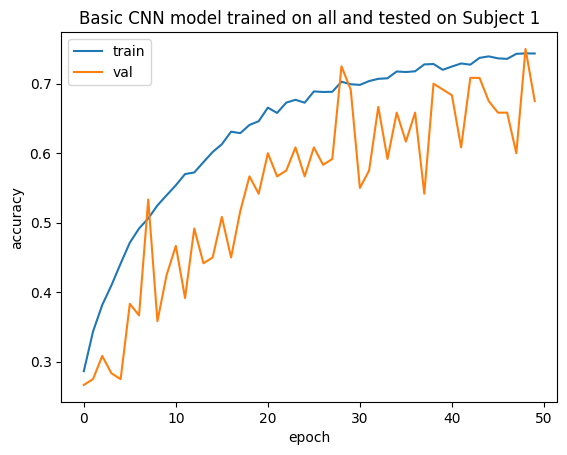

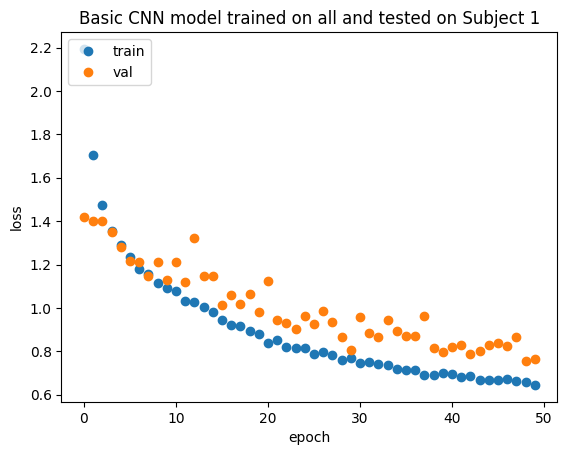

In [17]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(cnn_results_all_s1.history['accuracy'])
plt.plot(cnn_results_all_s1.history['val_accuracy'])
plt.title('Basic CNN model trained on all and tested on Subject 1')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_results_all_s1.history['loss'],'o')
plt.plot(cnn_results_all_s1.history['val_loss'],'o')
plt.title('Basic CNN model trained on all and tested on Subject 1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## CNN model trained on Subject 1 and tested on Subject 1

In [26]:
# Building the CNN model using sequential class
cnn_s1_s1 = Sequential()

# Conv. block 1
cnn_s1_s1.add(Conv2D(filters=25, kernel_size=(5,1), padding='same', activation='elu', input_shape=(500,1,22)))
cnn_s1_s1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_s1_s1.add(BatchNormalization())
cnn_s1_s1.add(Dropout(0.5))

# Conv. block 2
cnn_s1_s1.add(Conv2D(filters=50, kernel_size=(5,1), padding='same', activation='elu'))
cnn_s1_s1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_s1_s1.add(BatchNormalization())
cnn_s1_s1.add(Dropout(0.5))

# Conv. block 3
cnn_s1_s1.add(Conv2D(filters=100, kernel_size=(5,1), padding='same', activation='elu'))
cnn_s1_s1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_s1_s1.add(BatchNormalization())
cnn_s1_s1.add(Dropout(0.5))

# Conv. block 4
cnn_s1_s1.add(Conv2D(filters=200, kernel_size=(5,1), padding='same', activation='elu'))
cnn_s1_s1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_s1_s1.add(BatchNormalization())
cnn_s1_s1.add(Dropout(0.5))

# Output layer with Softmax activation
cnn_s1_s1.add(Flatten()) # Flattens the input
cnn_s1_s1.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

In [27]:
# Model parameters
learning_rate = 1e-3
epochs = 25
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
# Compiling the model
cnn_s1_s1.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_results_s1_s1 = cnn_s1_s1.fit(x_train_s1,
             y_train_s1,
             batch_size=16,
             epochs=epochs,
             validation_data=(x_valid_s1, y_valid_s1), verbose=True)

Epoch 1/25
52/52 [==============================] - 2s 24ms/step - loss: 2.2408 - accuracy: 0.3155 - val_loss: 2.5487 - val_accuracy: 0.2250
Epoch 2/25
52/52 [==============================] - 1s 21ms/step - loss: 1.8536 - accuracy: 0.3762 - val_loss: 1.5911 - val_accuracy: 0.3583
Epoch 3/25
52/52 [==============================] - 1s 20ms/step - loss: 1.7148 - accuracy: 0.4211 - val_loss: 1.5308 - val_accuracy: 0.3667
Epoch 4/25
52/52 [==============================] - 1s 20ms/step - loss: 1.5028 - accuracy: 0.4345 - val_loss: 1.6832 - val_accuracy: 0.3083
Epoch 5/25
52/52 [==============================] - 2s 30ms/step - loss: 1.3670 - accuracy: 0.4927 - val_loss: 1.5820 - val_accuracy: 0.3417
Epoch 6/25
52/52 [==============================] - 1s 21ms/step - loss: 1.3070 - accuracy: 0.5121 - val_loss: 1.6922 - val_accuracy: 0.4167
Epoch 7/25
52/52 [==============================] - 1s 20ms/step - loss: 1.1617 - accuracy: 0.5631 - val_loss: 1.7162 - val_accuracy: 0.3750
Epoch 8/25
52

In [28]:
## Testing the model
score_s1_s1 = cnn_s1_s1.evaluate(x_test_s1, y_test_s1, verbose=0)
print('Test accuracy of the vanilla CNN model when model is trained on subject 1 and tested on subject 1:', score_s1_s1[1])

Test accuracy of the vanilla CNN model when model is trained on subject 1 and tested on subject 1: 0.46000000834465027


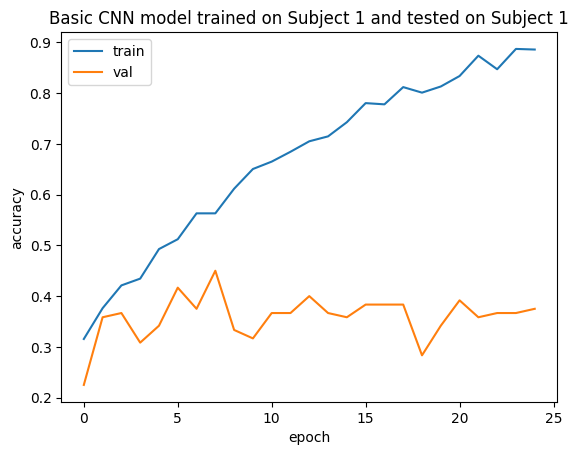

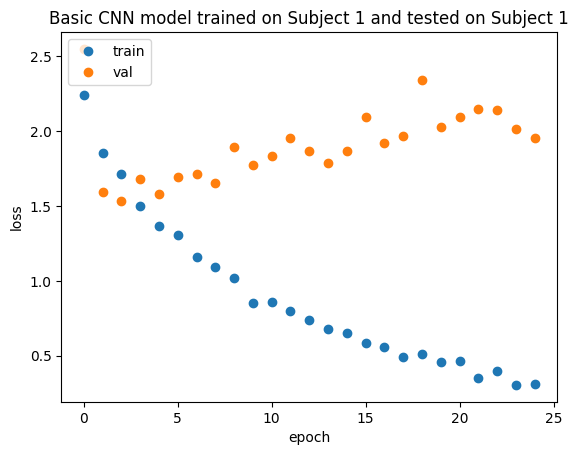

In [29]:
# Plotting accuracy trajectory
plt.plot(cnn_results_s1_s1.history['accuracy'])
plt.plot(cnn_results_s1_s1.history['val_accuracy'])
plt.title('Basic CNN model trained on Subject 1 and tested on Subject 1')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_results_s1_s1.history['loss'],'o')
plt.plot(cnn_results_s1_s1.history['val_loss'],'o')
plt.title('Basic CNN model trained on Subject 1 and tested on Subject 1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## CNN model trained on subject 1 and tested on all subjects

In [35]:
# Building the CNN model using sequential class
cnn_s1_all = Sequential()

# Conv. block 1
cnn_s1_all.add(Conv2D(filters=16, kernel_size=(5,1), padding='same', activation='elu', input_shape=(500,1,22)))
cnn_s1_all.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_s1_all.add(BatchNormalization())
cnn_s1_all.add(Dropout(0.6))

# Conv. block 2
cnn_s1_all.add(Conv2D(filters=32, kernel_size=(5,1), padding='same', activation='elu'))
cnn_s1_all.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_s1_all.add(BatchNormalization())
cnn_s1_all.add(Dropout(0.6))

# Conv. block 3
cnn_s1_all.add(Conv2D(filters=64, kernel_size=(5,1), padding='same', activation='elu'))
cnn_s1_all.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_s1_all.add(BatchNormalization())
cnn_s1_all.add(Dropout(0.6))

# Conv. block 4
cnn_s1_all.add(Conv2D(filters=128, kernel_size=(5,1), padding='same', activation='elu'))
cnn_s1_all.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_s1_all.add(BatchNormalization())
cnn_s1_all.add(Dropout(0.6))

# Output layer with Softmax activation
cnn_s1_all.add(Flatten()) # Flattens the input
cnn_s1_all.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

In [36]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
cnn_s1_all.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_results_s1_all = cnn_s1_all.fit(x_train_s1,
             y_train_s1,
             batch_size=32,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/50
26/26 [==============================] - 2s 38ms/step - loss: 2.6461 - accuracy: 0.2682 - val_loss: 4.3911 - val_accuracy: 0.2240
Epoch 2/50
26/26 [==============================] - 1s 30ms/step - loss: 2.4536 - accuracy: 0.2670 - val_loss: 1.9137 - val_accuracy: 0.2410
Epoch 3/50
26/26 [==============================] - 1s 29ms/step - loss: 2.1316 - accuracy: 0.3155 - val_loss: 1.6116 - val_accuracy: 0.2910
Epoch 4/50
26/26 [==============================] - 1s 29ms/step - loss: 2.0646 - accuracy: 0.3070 - val_loss: 1.5568 - val_accuracy: 0.3180
Epoch 5/50
26/26 [==============================] - 1s 28ms/step - loss: 1.9832 - accuracy: 0.3240 - val_loss: 1.6423 - val_accuracy: 0.3590
Epoch 6/50
26/26 [==============================] - 1s 54ms/step - loss: 1.7642 - accuracy: 0.3544 - val_loss: 1.5827 - val_accuracy: 0.3570
Epoch 7/50
26/26 [==============================] - 1s 32ms/step - loss: 1.8088 - accuracy: 0.3592 - val_loss: 1.6462 - val_accuracy: 0.3650
Epoch 8/50
26

In [37]:
## Testing the model
score_s1_all = cnn_s1_all.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the vanilla CNN model when model is trained on subject 1 and tested on subject 1:', score_s1_all[1])

Test accuracy of the vanilla CNN model when model is trained on subject 1 and tested on subject 1: 0.33182844519615173


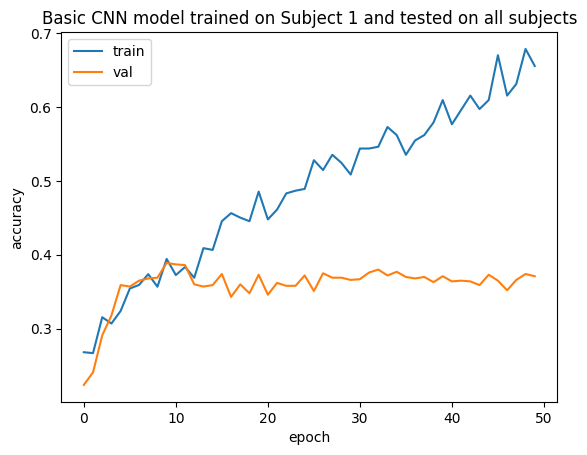

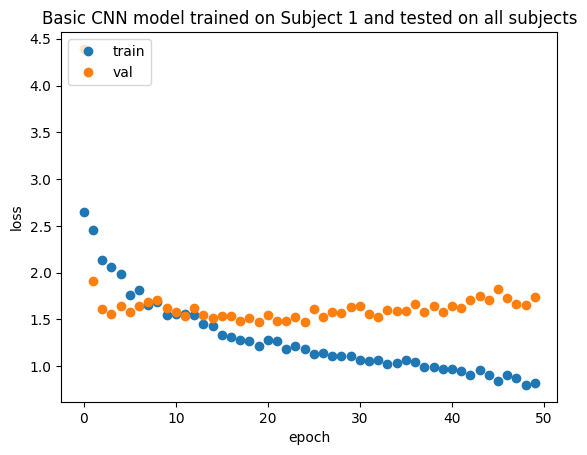

In [38]:
# Plotting accuracy trajectory
plt.plot(cnn_results_s1_all.history['accuracy'])
plt.plot(cnn_results_s1_all.history['val_accuracy'])
plt.title('Basic CNN model trained on Subject 1 and tested on all subjects')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_results_s1_all.history['loss'],'o')
plt.plot(cnn_results_s1_all.history['val_loss'],'o')
plt.title('Basic CNN model trained on Subject 1 and tested on all subjects')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()